In [ ]:
import os
import re
import joblib
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

import shap
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
RANDOM_STATE = 42


In [ ]:
files = {
    "TOI": "/content/TOI_cleaned_ML.csv",
    "Kepler": "/content/Kepler.csv",
    "K2": "/content/K2.csv",
}

def load_and_tag(files_dict):
    dfs = []
    for tag, path in files_dict.items():
        if not Path(path).exists():
            print(f"Warning: {path} not found. Skipping {tag}.")
            continue
        df = pd.read_csv(path)
        df['__source_dataset'] = tag
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("No input files found. Make sure file paths are correct.")
    return pd.concat(dfs, ignore_index=True, sort=False)

df = load_and_tag(files)
print("Combined shape:", df.shape)
print("Columns:", df.columns.tolist()[:50])


Combined shape: (21267, 104)
Columns: ['toi', 'toipfx', 'pl_pnum', 'ra', 'dec', 'st_pmra', 'st_pmraerr1', 'st_pmdec', 'pl_orbper', 'pl_orbpererr1', 'pl_trandurh', 'pl_trandurherr1', 'pl_trandep', 'pl_trandeperr1', 'pl_rade', 'pl_radeerr1', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_tmagerr1', 'st_dist', 'st_disterr1', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_logg', 'st_loggerr1', 'st_rad', 'st_raderr1', 'st_logg_missing', 'st_teff_missing', 'tfopwg_disp_CP', 'tfopwg_disp_FA', 'tfopwg_disp_FP', 'tfopwg_disp_KP', 'tfopwg_disp_PC', 'rastr_01h34m22.42s', 'rastr_03h41m50.17s', 'rastr_10h06m26.93s', 'decstr_-30d27m14.82s', '__source_dataset', 'koi_disposition', 'koi_period', 'koi_prad', 'koi_sma', 'koi_teq', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_slogg']


In [ ]:
label_candidates = [
    "label", "target", "is_planet", "planet", "disposition", "koi_disposition",
    "kep_flag", "LABEL", "DISPOSITION", "STATUS", "EXOPLANET_FLAG", "planet_candidate"
]

def detect_label_column(df, candidates=label_candidates):
    for c in candidates:
        if c in df.columns:
            return c
    lower_cols = {col.lower(): col for col in df.columns}
    for cand in candidates:
        if cand.lower() in lower_cols:
            return lower_cols[cand.lower()]
    for col in df.columns:
        nuni = df[col].nunique(dropna=True)
        if 2 <= nuni <= 4 and (df[col].dtype.kind in "biufcO"):
            return col
    return None

label_column = detect_label_column(df)


if label_column is None:
    raise ValueError(
        "Could not auto-detect the label column. Please set `label_column` manually "
        "to the name of the target column (e.g. 'is_planet' or 'disposition')."
    )

print("Using label column:", label_column)

Using label column: disposition


In [ ]:
drop_like = ['name', 'object', 'id', 'kepid', 'toi_id', 'kep_name', 'kepid', 'ticid']
mapping = {
    'PC': 1, 'CONFIRMED': 1, 'CANDIDATE': 1,
    'FP': 0, 'FALSE POSITIVE': 0, 'NO': 0, 'N': 0, 'REFUTED': 0
}

df[label_column] = df[label_column].apply(lambda x: mapping.get(str(x).strip().upper(), x))

drop_cols = [c for c in df.columns if any(re.fullmatch(fr".*{p}.*", c, re.I) for p in drop_like)]
cols_to_drop = [c for c in drop_cols if c != label_column]
df = df.drop(columns=cols_to_drop, errors='ignore')


print("Label value counts (pre-clean):")
print(df[label_column].value_counts(dropna=False).head(20))

Label value counts (pre-clean):
disposition
NaN    17263
1.0     3689
0.0      315
Name: count, dtype: int64


In [ ]:
label_column = 'tfopwg_disp_PC'

df = df[~df[label_column].isna()].copy()

numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
exclude_cols = [label_column, 'tfopwg_disp_CP', 'tfopwg_disp_FA', 'tfopwg_disp_FP', 'tfopwg_disp_KP']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

cat_cols = [c for c in df.columns if c not in numeric_cols + exclude_cols + ['__source_dataset']]

cat_cols = [c for c in cat_cols if df[c].nunique() <= 200]

print("Numeric features:", len(numeric_cols), "Categorical features:", len(cat_cols))

X = df[numeric_cols + cat_cols].copy()
y = df[label_column].astype(float)

Numeric features: 84 Categorical features: 9


In [ ]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, cat_cols),
], remainder='drop')

In [ ]:
clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', clf)
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# Apply preprocessing to the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


baseline_params = dict(
    clf__n_estimators=100,
    clf__max_depth=6,
    clf__learning_rate=0.1,
    clf__subsample=0.8,
    clf__colsample_bytree=0.8
)
pipeline.set_params(**baseline_params)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print("Baseline classification report:")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Baseline classification report:
              precision    recall  f1-score   support

         0.0     0.7713    0.6308    0.6940       604
         1.0     0.7868    0.8793    0.8305       936

    accuracy                         0.7818      1540
   macro avg     0.7790    0.7550    0.7622      1540
weighted avg     0.7807    0.7818    0.7769      1540

ROC AUC: 0.8528594979340013


In [ ]:
print("Value counts for 'disposition' after mapping (before filtering):")
print(df['disposition'].value_counts(dropna=False))

Value counts for 'disposition' after mapping (before filtering):
disposition
NaN    7699
Name: count, dtype: int64


In [ ]:
print("Value counts for 'tfopwg_disp_PC' before filtering:")
print(df['tfopwg_disp_PC'].value_counts(dropna=False))

Value counts for 'tfopwg_disp_PC' before filtering:
tfopwg_disp_PC
True     4678
False    3021
Name: count, dtype: int64


In [ ]:
param_dist = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [3, 5, 7, 9],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.5, 0.8, 1.0],
    'clf__reg_alpha': [0, 1e-2, 0.1, 1],
    'clf__reg_lambda': [1, 10, 50]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
rs = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=30, scoring='roc_auc', cv=cv, verbose=2, random_state=RANDOM_STATE, n_jobs=-1
)

rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV score (ROC AUC):", rs.best_score_)

best_pipeline = rs.best_estimator_
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:,1]
print("Test classification report (best):")
print(classification_report(y_test, y_pred, digits=4))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best params: {'clf__subsample': 1.0, 'clf__reg_lambda': 10, 'clf__reg_alpha': 1, 'clf__n_estimators': 500, 'clf__max_depth': 9, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.5}
Best CV score (ROC AUC): 0.8575342810564208
Test classification report (best):
              precision    recall  f1-score   support

         0.0     0.7843    0.6623    0.7181       604
         1.0     0.8019    0.8825    0.8403       936

    accuracy                         0.7961      1540
   macro avg     0.7931    0.7724    0.7792      1540
weighted avg     0.7950    0.7961    0.7924      1540

Test ROC AUC: 0.8612720750551877


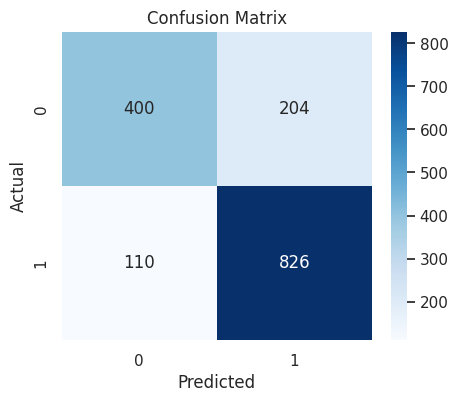

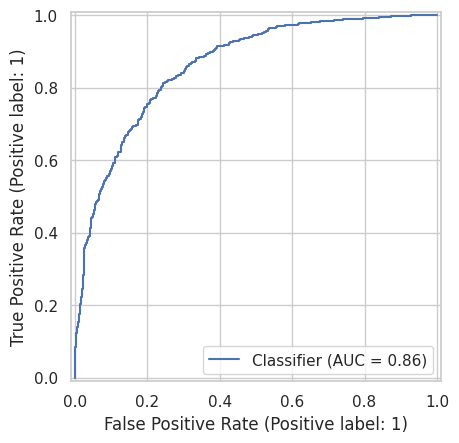

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

# ROC plot
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


Number of features after preprocessing: 44


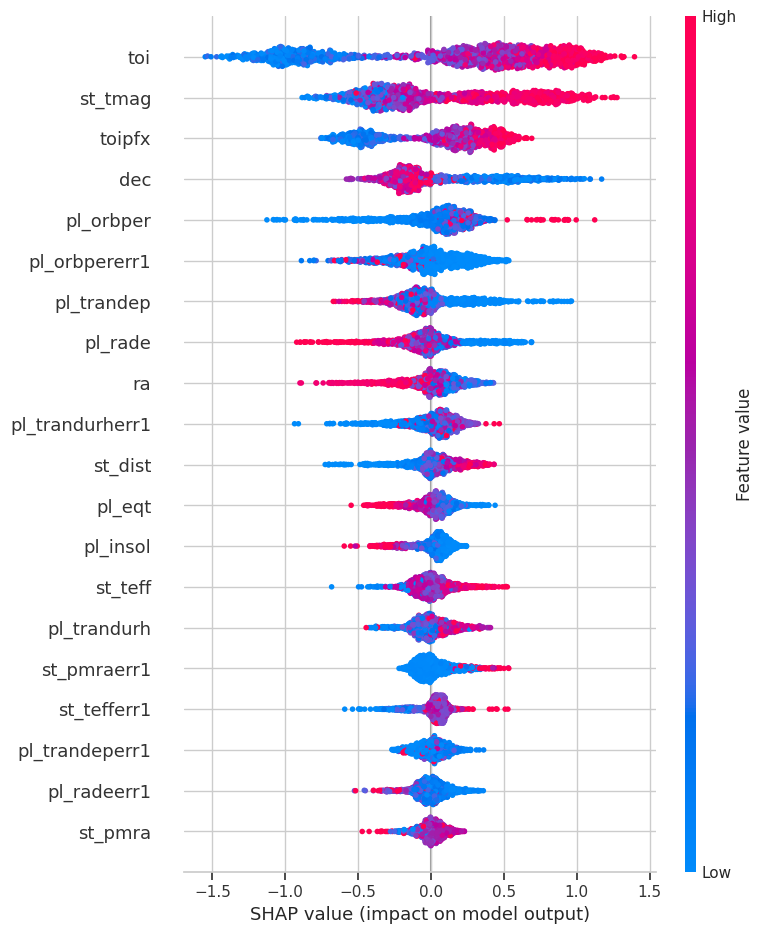

Top feature: toi


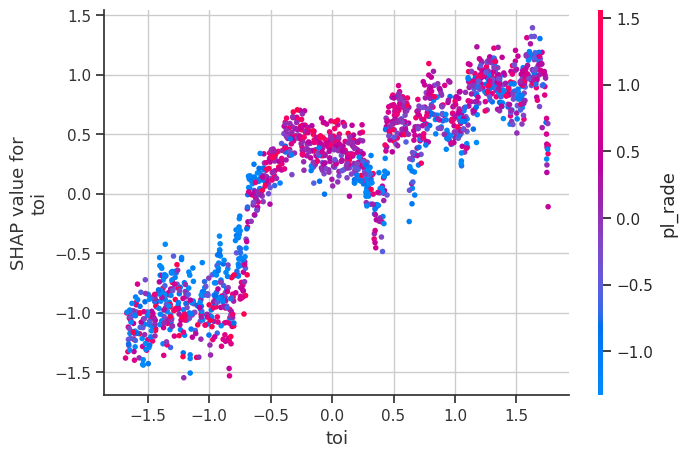

In [ ]:
def get_feature_names(preprocessor):
    num_names = numeric_cols
    cat_ohe = []
    if cat_cols:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        ohe_feat_names = ohe.get_feature_names_out(cat_cols)
        cat_ohe = list(ohe_feat_names)
    return num_names + cat_ohe

preproc = best_pipeline.named_steps['preproc']
xgb_model = best_pipeline.named_steps['clf']

X_test_trans = preproc.transform(X_test)
feature_names = get_feature_names(preproc)
print("Number of features after preprocessing:", X_test_trans.shape[1])

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, show=True)

top_feature = feature_names[np.argsort(np.abs(shap_values).mean(0))[-1]]
print("Top feature:", top_feature)
shap.dependence_plot(top_feature, shap_values, X_test_trans, feature_names=feature_names, show=True)


In [ ]:
out_path = "xgb_exoplanet_pipeline.joblib"
joblib.dump(best_pipeline, out_path)
print("Saved pipeline to:", out_path)


Saved pipeline to: xgb_exoplanet_pipeline.joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.download("xgb_exoplanet_pipeline.joblib")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import xgboost, sklearn, pandas, numpy, joblib
print("xgboost==", xgboost.__version__)
print("scikit-learn==", sklearn.__version__)
print("pandas==", pandas.__version__)
print("numpy==", numpy.__version__)



xgboost== 3.0.5
scikit-learn== 1.6.1
pandas== 2.2.2
numpy== 2.0.2
